In [1]:
%matplotlib inline
import numpy as np
import urllib
import urllib2
import os

import h5py

from astropy.io import fits
from astropy import wcs
from astropy.table import Table, Column, vstack

import matplotlib.pyplot as plt

import galsim

from kungpao import imtools
from kungpao import io
from kungpao.display import display_single, IMG_CMAP, SEG_CMAP

from IPython.display import clear_output

plt.rc('text', usetex=True)
HSC_pixel_scale = 0.168

## Generate Mock Image and save it to a HDF5 file

### Download HSC background given `ra`, `dec` and size

In [2]:
def gen_url_s18a(ra, dec, w, h, band):
    return ['https://hscdata.mtk.nao.ac.jp/das_quarry/dr2.1/cgi-bin/cutout?ra='
       + str(ra) 
       + '&dec='
       + str(dec)
       + '&sw='
       + str(w)
       + 'asec&sh='
       + str(h)
       + 'asec&type=coadd&image=on&variance=on&filter=HSC-'
       + str(band.upper())
       + '&tract=&rerun=s18a_wide']
def gen_url_s16a(ra, dec, w, h, band):
    return ['https://hscdata.mtk.nao.ac.jp/das_quarry/dr1/cgi-bin/quarryImage?ra='
       + str(ra) 
       + '&dec='
       + str(dec)
       + '&sw='
       + str(w)
       + 'asec&sh='
       + str(h)
       + 'asec&type=coadd&image=on&variance=on&filter=HSC-'
       + str(band.upper())
       + '&tract=&rerun=s16a_wide2']

### Login NAOJ account. You can replace the username and password by yours, instead of using a `config` file.

In [3]:
# Import HSC username and password
config = Table.read('/Users/jiaxuanli/Documents/HSC_config', format='ascii.no_header')['col1']
username = config[0]
password = config[1]
# Create a password manager
password_mgr = urllib2.HTTPPasswordMgrWithDefaultRealm()

# Add the username and password.
top_level_url = 'https://hscdata.mtk.nao.ac.jp/das_quarry/dr2.1/'
password_mgr.add_password(None, top_level_url, username, password)
handler = urllib2.HTTPBasicAuthHandler(password_mgr)

# create "opener" (OpenerDirector instance)
opener = urllib2.build_opener(handler)

# use the opener to fetch a URL
opener.open(top_level_url)

# Install the opener.
# Now all calls to urllib2.urlopen use our opener.
urllib2.install_opener(opener)

In [4]:
ra_bkg = 211.883587054072 
dec_bkg = -0.6322683634602501
size = 600 # pixel, half_size. The actual size will be 1200*1200.

url = gen_url_s18a(ra_bkg, dec_bkg, size * HSC_pixel_scale, size * HSC_pixel_scale, 'r')[0]
fits_data = fits.open(url, cache=False)

In [5]:
f = h5py.File('test_h5.h5','w')
dt = h5py.special_dtype(vlen=str)

info = f.create_dataset('info', (10,2), dtype='S10')
info[0] = 'edition', 's18a'
info[1] = 'ra', 211.883587054072
info[2] = 'dec', -0.6322683634602501
info[3] = 'size (pix)', 2*size

g1 = f.create_group('background')
g1.create_dataset('primary_header', data=fits_data[0].header.tostring(), dtype=dt)
g1.create_dataset('image', data=fits_data[1].data)
g1.create_dataset('image_header', data=fits_data[1].header.tostring(), dtype=dt)
g1.create_dataset('variance', data=fits_data[3].data)
g1.create_dataset('variance_header', data=fits_data[3].header.tostring(), dtype=dt)

g2 = f.create_group('ModelImage')
g3 = f.create_group('MockImage')

f.close()

### Generate mock image

In [6]:
def h5_gen_mock_image(h5_path, pixel_scale, i_gal_flux, i_gal_rh, i_gal_q, i_sersic_index, i_gal_beta, i_psf_rh):
    f = h5py.File(h5_path, 'r+')
    field = f['background']['image'][:]
    w = wcs.WCS(f['background']['image_header'].value)
    cen = field.shape[0] / 2  # Central position of the image
    print 'Size (in pixel):', [cen * 2, cen * 2]
    print 'Angular size (in arcsec):', [
        cen * 2 * pixel_scale, cen * 2 * pixel_scale
    ]
    print 'The center of this image:', [cen, cen]
    # Define sersic galaxy
    gal = galsim.Sersic(i_sersic_index, half_light_radius=i_gal_rh, flux=i_gal_flux)
    # Shear the galaxy by some value.
    # q, beta      Axis ratio and position angle: q = b/a, 0 < q < 1
    gal_shape = galsim.Shear(q=i_gal_q, beta=i_gal_beta * galsim.degrees)
    gal = gal.shear(gal_shape)
    # Define the PSF profile
    #psf = galsim.Moffat(beta=psf_beta, flux=1., half_light_radius=psf_rh)
    psf = galsim.Gaussian(sigma=i_psf_rh, flux=1.)
    # Convolve galaxy with PSF
    final = galsim.Convolve([gal, psf])
    # Draw the image with a particular pixel scale.
    image = final.drawImage(scale=pixel_scale, nx=2 * cen + 1, ny=2 * cen + 1)
    
    f['ModelImage'].create_dataset('n' + str(i_sersic_index), data=image.array)
    
    
    # Generate mock image
    mock_img = image.array + field
    # Plot fake galaxy and the composite mock image
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6))
    display_single(image.array, ax=ax1, scale_bar_length=10)
    display_single(mock_img, scale_bar_length=10, ax=ax2)
    plt.show(block=False)
    plt.subplots_adjust(wspace=0.)
    
    f['MockImage'].create_dataset('n' + str(i_sersic_index), data=mock_img)
    f.close()

#### S18A, N=4

Size (in pixel): [1200, 1200]
Angular size (in arcsec): [201.60000000000002, 201.60000000000002]
The center of this image: [600, 600]


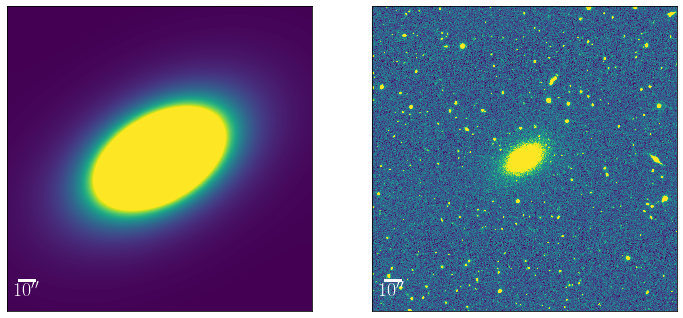

<Figure size 432x288 with 0 Axes>

In [7]:
gal_flux = 3.e4  # total counts on the image
gal_rh = 3.  # arcsec
gal_q = 0.6  # b/a
sersic_index = 4
gal_beta = 30.  # degrees
psf_beta = 5
psf_rh = 0.7  # arcsec
noise = 2.  # standard deviation of the counts in each pixel
h5_gen_mock_image('./test_h5.h5', HSC_pixel_scale,
               gal_flux, gal_rh, gal_q, sersic_index, gal_beta, psf_rh)

#### S18A, N=6

Size (in pixel): [1200, 1200]
Angular size (in arcsec): [201.60000000000002, 201.60000000000002]
The center of this image: [600, 600]


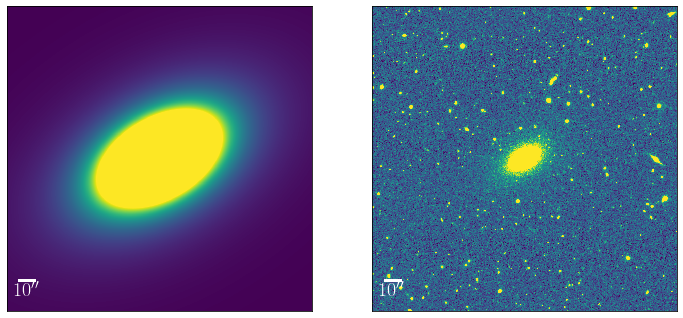

<Figure size 432x288 with 0 Axes>

In [8]:
gal_flux = 3.e4  # total counts on the image
gal_rh = 3.  # arcsec
gal_q = 0.6  # b/a
sersic_index = 6
gal_beta = 30.  # degrees
psf_beta = 5
psf_rh = 0.7  # arcsec
noise = 2.  # standard deviation of the counts in each pixel
h5_gen_mock_image('./test_h5.h5', HSC_pixel_scale,
               gal_flux, gal_rh, gal_q, sersic_index, gal_beta, psf_rh)

## Go through the structure of this HDF5 file

In [9]:
f = h5py.File('./first_file.h5', 'r')
def print_attrs(name, obj):
    print name
    for key, val in obj.attrs.iteritems():
        print "    %s: %s" % (key, val)

f.visititems(print_attrs)
f.close()

MockImage
MockImage/n4
MockImage/n6
ModelImage
ModelImage/n4
ModelImage/n6
background
background/image
background/image_header
background/primary_header
background/variance
background/variance_header
info


***
# Download background images according to the given catalog

## Import sky objects as the position of putting fake galaxies

In [123]:
pos_cat = Table.read('../easy/fake_gal_pos.fits', format='fits')
pos_cat

object_id,i_ra,i_dec,tract,patch,g_pixelflags,r_pixelflags,i_pixelflags,z_pixelflags,y_pixelflags,g_localbackground_flux,g_localbackground_fluxsigma,r_localbackground_flux,r_localbackground_fluxsigma,i_localbackground_flux,i_localbackground_fluxsigma,z_localbackground_flux,z_localbackground_fluxsigma,y_localbackground_flux,y_localbackground_fluxsigma,g_apertureflux_20_flux,g_apertureflux_20_fluxsigma,g_apertureflux_20_flag,g_apertureflux_30_flux,g_apertureflux_30_fluxsigma,g_apertureflux_30_flag,g_apertureflux_40_flux,g_apertureflux_40_fluxsigma,g_apertureflux_40_flag,g_apertureflux_57_flux,g_apertureflux_57_fluxsigma,g_apertureflux_57_flag,g_apertureflux_84_flux,g_apertureflux_84_fluxsigma,g_apertureflux_84_flag,g_apertureflux_118_flux,g_apertureflux_118_fluxsigma,g_apertureflux_118_flag,r_apertureflux_20_flux,r_apertureflux_20_fluxsigma,r_apertureflux_20_flag,r_apertureflux_30_flux,r_apertureflux_30_fluxsigma,r_apertureflux_30_flag,r_apertureflux_40_flux,r_apertureflux_40_fluxsigma,r_apertureflux_40_flag,r_apertureflux_57_flux,r_apertureflux_57_fluxsigma,r_apertureflux_57_flag,r_apertureflux_84_flux,r_apertureflux_84_fluxsigma,r_apertureflux_84_flag,r_apertureflux_118_flux,r_apertureflux_118_fluxsigma,r_apertureflux_118_flag,i_apertureflux_20_flux,i_apertureflux_20_fluxsigma,i_apertureflux_20_flag,i_apertureflux_30_flux,i_apertureflux_30_fluxsigma,i_apertureflux_30_flag,i_apertureflux_40_flux,i_apertureflux_40_fluxsigma,i_apertureflux_40_flag,i_apertureflux_57_flux,i_apertureflux_57_fluxsigma,i_apertureflux_57_flag,i_apertureflux_84_flux,i_apertureflux_84_fluxsigma,i_apertureflux_84_flag,i_apertureflux_118_flux,i_apertureflux_118_fluxsigma,i_apertureflux_118_flag,z_apertureflux_20_flux,z_apertureflux_20_fluxsigma,z_apertureflux_20_flag,z_apertureflux_30_flux,z_apertureflux_30_fluxsigma,z_apertureflux_30_flag,z_apertureflux_40_flux,z_apertureflux_40_fluxsigma,z_apertureflux_40_flag,z_apertureflux_57_flux,z_apertureflux_57_fluxsigma,z_apertureflux_57_flag,z_apertureflux_84_flux,z_apertureflux_84_fluxsigma,z_apertureflux_84_flag,z_apertureflux_118_flux,z_apertureflux_118_fluxsigma,z_apertureflux_118_flag,y_apertureflux_20_flux,y_apertureflux_20_fluxsigma,y_apertureflux_20_flag,y_apertureflux_30_flux,y_apertureflux_30_fluxsigma,y_apertureflux_30_flag,y_apertureflux_40_flux,y_apertureflux_40_fluxsigma,y_apertureflux_40_flag,y_apertureflux_57_flux,y_apertureflux_57_fluxsigma,y_apertureflux_57_flag,y_apertureflux_84_flux,y_apertureflux_84_fluxsigma,y_apertureflux_84_flag,y_apertureflux_118_flux,y_apertureflux_118_fluxsigma,y_apertureflux_118_flag
int64,float64,float64,int16,int16,bool,bool,bool,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,bool,float64,float64,bool,float64,float64,bool,float64,float64,bool,float64,float64,bool,float64,float64,bool,float64,float64,bool,float64,float64,bool,float64,float64,bool,float64,float64,bool,float64,float64,bool,float64,float64,bool,float64,float64,bool,float64,float64,bool,float64,float64,bool,float64,float64,bool,float64,float64,bool,float64,float64,bool,float64,float64,bool,float64,float64,bool,float64,float64,bool,float64,float64,bool,float64,float64,bool,float64,float64,bool,float64,float64,bool,float64,float64,bool,float64,float64,bool,float64,float64,bool,float64,float64,bool
45859006496911373,343.6873637835255,5.582635497444793,10427,406,False,False,False,False,False,9.557343006135011e-34,3.1112675947443415e-32,1.2847427477879119e-33,6.484153426151602e-32,1.3478366334021728e-33,5.137433114534315e-32,4.7444399349885764e-33,8.139286811698464e-32,3.216287053835959e-33,1.8962693522443928e-31,-2.291259520527808e-32,3.378442680818262e-31,True,7.958946318917992e-31,5.082743015075432e-31,True,8.352299744024844e-31,6.76566656423635e-31,True,-1.9443058094396226e-31,9.538293727843837e-31,True,1.92636591062301e-30,1.3968258495360336e-30,True,4.916380281583696e-30,1.9741902291646977e-30,True,5.207334430073962e-31,7.105

Size (in pixel): [1200, 1200]
Angular size (in arcsec): [201.60000000000002, 201.60000000000002]
The center of this image: [600, 600]


<Figure size 432x288 with 0 Axes>

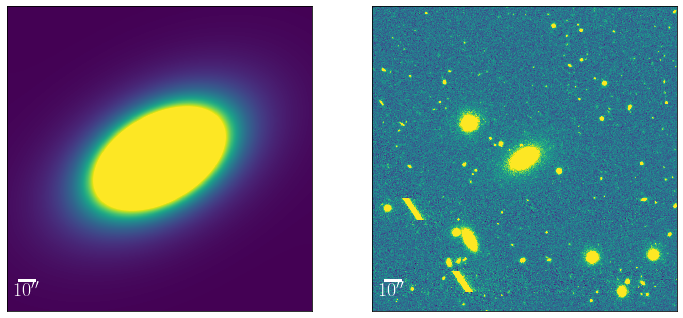

Size (in pixel): [1200, 1200]
Angular size (in arcsec): [201.60000000000002, 201.60000000000002]
The center of this image: [600, 600]


<Figure size 432x288 with 0 Axes>

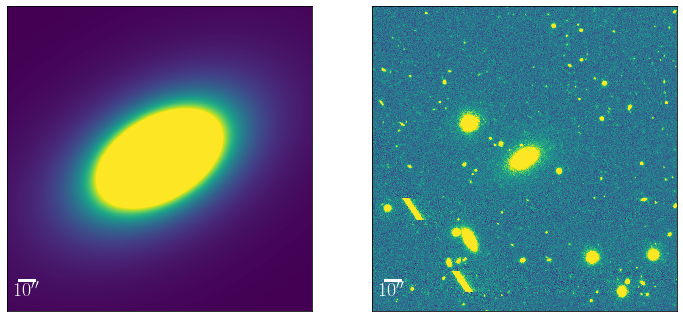

<Figure size 432x288 with 0 Axes>

In [140]:
for obj in pos_cat[:3]:
    clear_output()
    i = obj.index
    filename = 'MockGalaxy-'+ ("%03d" % i) + '.h5'
    if os.path.isfile(filename):
        os.remove(filename)
    
    # Download background image
    size = 600 # pixel, half_size. The actual size will be 1200*1200.
    url = gen_url_s18a(obj['i_ra'], obj['i_dec'], size * HSC_pixel_scale, size * HSC_pixel_scale, 'r')[0]
    fits_data = fits.open(url, cache=False)
    
    # Construct HDF5 file
    f = h5py.File(filename,'w')
    dt = h5py.special_dtype(vlen=str)
    
    info = f.create_dataset('info', (10,2), dtype='S10')
    info[0] = 'edition', 's18a'
    info[1] = 'ra', obj['i_ra']
    info[2] = 'dec', obj['i_dec']
    info[3] = 'size (pix)', 2 * size

    g1 = f.create_group('background')
    g1.create_dataset('primary_header', data=fits_data[0].header.tostring(), dtype=dt)
    g1.create_dataset('image', data=fits_data[1].data)
    g1.create_dataset('image_header', data=fits_data[1].header.tostring(), dtype=dt)
    g1.create_dataset('variance', data=fits_data[3].data)
    g1.create_dataset('variance_header', data=fits_data[3].header.tostring(), dtype=dt)

    g2 = f.create_group('ModelImage')
    g3 = f.create_group('MockImage')
    
    # Parameters of fake galaxy
    gal_flux = 3.e4  # total counts on the image
    gal_rh = 3.  # arcsec
    gal_q = 0.6  # b/a
    gal_beta = 30.  # degrees
    psf_beta = 5
    psf_rh = 0.7  # arcsec
    
    # Sersic index
    sersic_index = 4
    h5_gen_mock_image(filename, HSC_pixel_scale,
                   gal_flux, gal_rh, gal_q, sersic_index, gal_beta, psf_rh)
    # Sersic index
    sersic_index = 6
    h5_gen_mock_image(filename, HSC_pixel_scale,
                   gal_flux, gal_rh, gal_q, sersic_index, gal_beta, psf_rh)
    f.close()